lab 6

In [1]:
 import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

In [3]:
q1_sql = """
SELECT
    curr.year,
    curr.pop AS current_population,
    prev.pop AS previous_population,
    ROUND(
        (CAST(curr.pop AS NUMERIC) - prev.pop) / prev.pop * 100,
        2
    ) AS growth_rate_percent
FROM
    population curr
JOIN
    population prev ON curr.fips = prev.fips AND curr.year = prev.year + 1
JOIN
    name n ON curr.fips = n.fips
WHERE
    n.name = 'Wyoming';

"""

In [4]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_19630/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,current_population,previous_population,growth_rate_percent
0,2006,515004,495226,3.99
1,2007,522830,515004,1.52
2,2008,532668,522830,1.88
3,2009,544270,532668,2.18
4,2010,564460,544270,3.71


<Axes: title={'center': 'Growth Rate Percent in Wyoming'}, xlabel='year'>

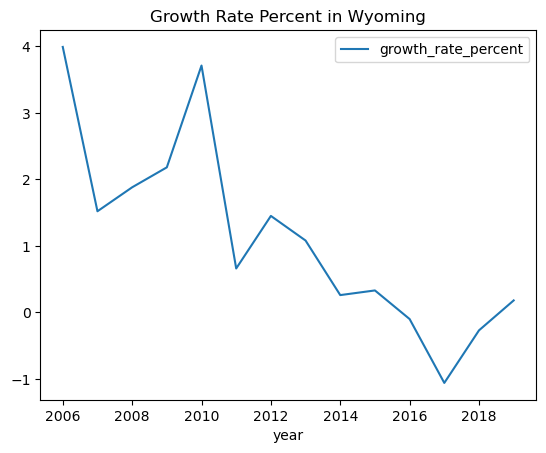

In [5]:
q1_df.plot(x='year', y='growth_rate_percent', title='Growth Rate Percent in Wyoming')

This is a useful representation when analyzing the trends within Wyoming. It can be seen that the population in Wyoming has been decreasing over the years, with sharp spikes, and vast improvements in population in around 2017. This prompts further investigation of what has had the impact on Wyomings population.

In [6]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [10]:
%load_ext jupyter_ai_magics

In [11]:
%%ai gpt4
What is included in the {q1_df}

The data provided includes the following information for each year from 2006 to 2019:

- `year`: Specifies the listed year.
- `current_population`: Indicates the population of the year specified.
- `previous_population`: Specifies the population of the year preceding the one listed.
- `growth_rate_percent`: Shows the percentage increase or decrease in population from the previous year to the current year.

For example, in 2006, the population was 515,004. This was a 3.99% increase from the population of the previous year (495,226). By 2019, the population has grown to 578,759, indicating a 0.18% increase from the population in 2018 (577,737).

In [12]:
%%ai gpt4 -f code
use the data in {q1_df}, creates a line chart with the growth rate.
    Chart must include the WY state name in the title

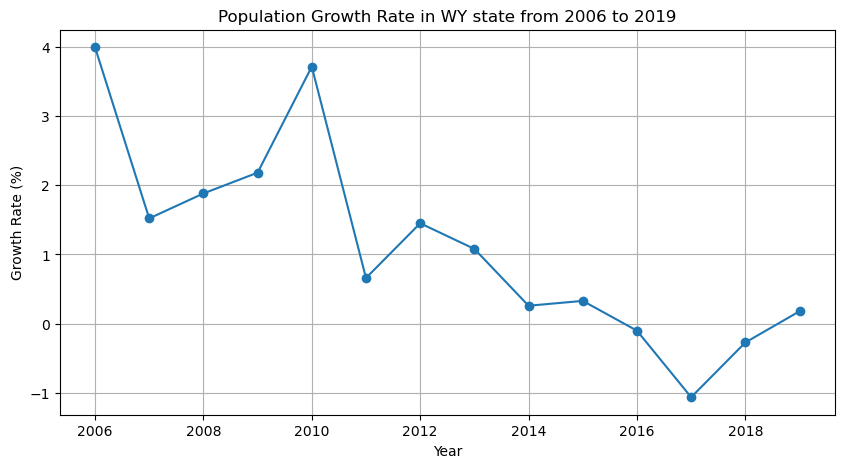

In [18]:
import matplotlib.pyplot as plt

year = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
growth_rate_percent = [3.99, 1.52, 1.88, 2.18, 3.71, 0.66, 1.45, 1.08, 0.26, 0.33, -0.10, -1.06, -0.27, 0.18]

plt.figure(figsize=(10,5))
plt.plot(year, growth_rate_percent, marker='o')
plt.title('Population Growth Rate in WY state from 2006 to 2019')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

From 2007- 2010, Wyoming saw the highest amount of population growth rate they have seen in the last two decades. However despite this fast growth, between 2012 and 2017 the population saw a steady decline and the lowest amount of growth yet. However seeing minor increases in growth rate from 2018+, it can be assumed this growth went stagnant like years prior. 

## Q2 - Income and Population Relationship

In [20]:
q2_sql = """
SELECT 
       n.name AS state_name,
       p.year,
       p.pop AS population,
       i.income AS income
FROM population AS p
JOIN income AS i
     ON p.fips = i.fips AND p.year = i.year
JOIN name AS n
     ON p.fips = n.fips
WHERE p.fips = '56'
ORDER BY p.year ASC;
"""

In [21]:
q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

/tmp/ipykernel_19630/726951156.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,state_name,year,population,income
0,Wyoming,2005,495226,46202
1,Wyoming,2006,515004,47423
2,Wyoming,2007,522830,51731
3,Wyoming,2008,532668,53207
4,Wyoming,2009,544270,52664


In [22]:
%%ai gpt4 -f code
use the data in {q2_df}, isualization: create a dual-axis chart in Python with Jupyter AI’s help:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name in the title.


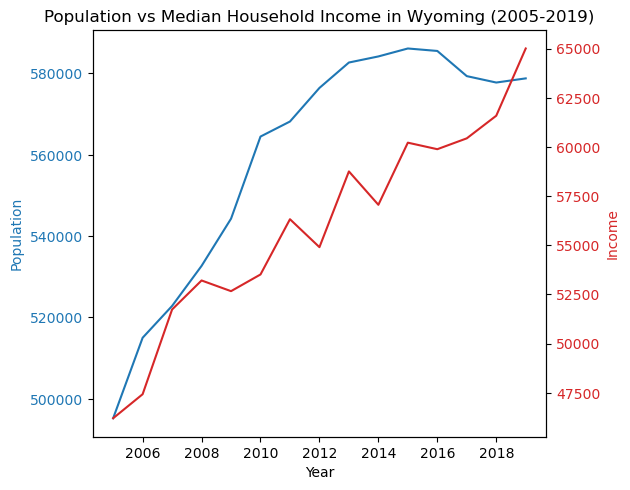

In [24]:
import matplotlib.pyplot as plt

state_name = 'Wyoming'
year = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
population = [495226, 515004, 522830, 532668, 544270, 564460, 568158, 576412, 582658, 584153, 586107, 585501, 579315, 577737, 578759]
income = [46202, 47423, 51731, 53207, 52664, 53512, 56322, 54901, 58752, 57055, 60214, 59882, 60434, 61584, 65003]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(year, population, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Income', color=color)  
ax2.plot(year, income, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Population vs Median Household Income in ' + state_name + ' (2005-2019)')
plt.show()

It is an interesting comparison between population and income in this graph. Within the graph, the steady increase in income over the years (despite the sharp drops) calls for attention. A possible assumption is that the increased income and population overtime could be because people worked harder and made more money as they had more children. However, further investigations would be needed to explain the sharp dips in income, all while the population steadily increased until 2018. Yet, in general both the population and income of Wyoming have been steadily increasing over the last two decades. 

## Q3 - Student Defined Question

In which year did Wyoming have the lowest income?

In [25]:
q3_sql = """
SELECT 
    n.name AS state_name,
    i.year,
    i.income
FROM 
    income AS i
JOIN 
    name AS n 
    ON i.fips = n.fips
WHERE 
    i.fips = 56
ORDER BY 
    i.income ASC
LIMIT 1;
"""

In [26]:
%%ai gpt4 -f code
# Use the data in {q3_sql}.
# Visualization: create a simple line chart in Python showing Wyoming's income by year.
# X-axis = year
# Y-axis = income
# Highlight the year with the lowest income (different color or marker).
# Include the state name and context in the title.



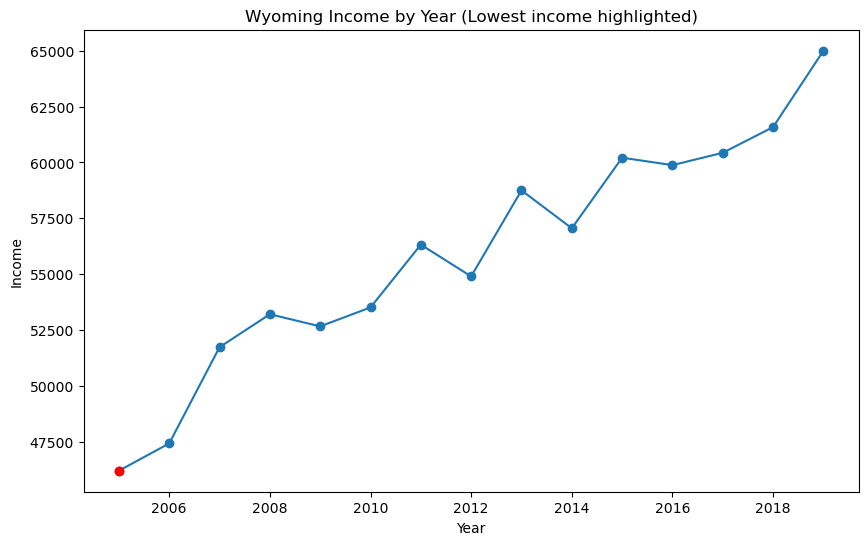

In [28]:
import matplotlib.pyplot as plt

# Assuming you executed the SQL query and got the following results
state_name = 'Wyoming'
income_data = {2005: 46202, 2006: 47423, 2007: 51731, 2008: 53207, 2009: 52664, 2010: 53512, 2011: 56322, 2012: 54901, 2013: 58752, 2014: 57055, 2015: 60214, 2016: 59882, 2017: 60434, 2018: 61584, 2019: 65003}

years = list(income_data.keys())
income = list(income_data.values())

# Find the year with the lowest income
lowest_year = years[income.index(min(income))]

# Create line chart
plt.figure(figsize=(10, 6))
plt.plot(years, income, marker='o')
plt.plot(lowest_year, income_data[lowest_year], marker='o', color='r')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Income')
plt.title(f'{state_name} Income by Year (Lowest income highlighted)')

# Show the plot
plt.show()

Within this graph, we can identify that the lowest income within the data for Wyoming was around 2005-2006. While a simple statistics, we can draw insights into how after 2006 the income continually rose. This would allow for a data-supported and trend based analytical project. 